## Tabulations and figures for CCS-lobbying-activity analysis
Lindsey Gulden, lindsey@legupdata.com
October 2024, updated February 2025
Contains general summary information as well as tables and figures used for Gulden and Harvey ES&P paper, submitted Feb 2025

In [1]:

import pandas as pd
from math import ceil

from utils.io import yaml_to_dict
from projects.lobbying.postproc_utils import terms_present
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from plotly.subplots import make_subplots

import plotly.graph_objects as go


import re
import matplotlib.patheffects as pe
from pathlib import Path
import plotly.express as px

import warnings

warnings.filterwarnings("ignore")
%load_ext jupyter_black

### Define bespoke functions for data processing and analysis

In [2]:
def split_on_char(x: str, character="\n"):
    n_char = x.count(character)
    if n_char == 0:
        return (x, "")

    indiv_orgs = x.split(character)
    first_group = character.join(indiv_orgs[: (ceil((n_char + 1) / 2))])
    second_group = character.join(indiv_orgs[(ceil((n_char + 1) / 2)) :])
    return (first_group, second_group)


def split_on_char3(x: str, character="\n"):
    n_char = x.count(character)
    if n_char == 0:
        return (x, "")

    indiv_orgs = x.split(character)
    first_group = character.join(indiv_orgs[: (ceil((n_char + 1) / 3))])
    second_group = character.join(
        indiv_orgs[(ceil((n_char + 1) / 3)) : 2 * (ceil((n_char + 1) / 3))]
    )
    third_group = character.join(indiv_orgs[2 * (ceil((n_char + 1) / 3)) :])
    return (first_group, second_group, third_group)


## Bespoke funciton to trim dates treated when importing files (to avoid roping in data from years outside of desired
def trim_dates(
    df: pd.DataFrame,
    yr: int,
    period: int,
    yr_col: str,
    period_col: str,
    how: str = "lte",
):
    num_period_col = "numeric_filing_period"
    df[num_period_col] = df[period_col].replace(
        {
            "first_quarter": 1,
            "second_quarter": 2,
            "third_quarter": 3,
            "fourth_quarter": 4,
            "mid_year": 2,
            "year_end": 4,
        }
    )
    df[yr_col] = df[yr_col].astype(int)
    if how == "lte":
        return df.loc[
            (df[yr_col] < yr) | ((df[yr_col] == yr) & df[num_period_col] <= period)
        ]
    elif how == "lt":
        return df.loc[
            (df[yr_col] < yr) | ((df[yr_col] == yr) & df[num_period_col] < period)
        ]
    elif how == "gte":
        return df.loc[
            (df[yr_col] > yr) | ((df[yr_col] == yr) & df[num_period_col] >= period)
        ]
    elif how == "gt":
        return df.loc[
            (df[yr_col] > yr) | ((df[yr_col] == yr) & df[num_period_col] > period)
        ]
    else:
        raise ValueError(
            'trim_dates paramter how must be one of the following strings: "lte", "lt", "gte", "gt"'
        )

### PATHS TO POSTPROCESSED DATA, YAML CONFIGURATIONS

In [3]:
DATA_DIR = Path("/Volumes/Samsung_T5/data/lobbying/data_for_lobbying_paper/")
PATH_TO_POSTPROCESSED_FILINGS = DATA_DIR / Path("all_ccs_postprocessed_filings.csv")
PATH_TO_POSTPROCESSED_STEEL_INDUSTRY_FILINGS = DATA_DIR / Path(
    "steel_iron_orgs_postprocessed_filings.csv"
)
PATH_TO_POSTPROCESSED_BIG_SPENDERS_FILINGS = DATA_DIR / Path(
    "oil_and_gas_orgs_postprocessed_filings.csv"
)
PATH_TO_POSTPROC_SPECS_YAML = "/Users/lindseygulden/dev/leg-up-private/projects/lobbying/definitions/ccs_postproc_specifications.yml"

PATH_TO_HIGHER_EDUCATION_POSTPROC_LOBBYING_FILINGS = DATA_DIR / Path(
    "university_postprocessed_filings.csv"
)

### Load postprocessed data, summarize general counts

In [6]:
df = trim_dates(
    pd.read_csv(PATH_TO_POSTPROCESSED_FILINGS),
    yr=2024,
    period=4,
    how="lte",
    yr_col="filing_year",
    period_col="filing_period",
)
df = df.loc[df.organization != "UNCATEGORIZED"]
df[
    [
        "ccs_company",
        "contains_description",
        "ccs_bills",
        "ccs_bills_number_only",
        "bills_with_ccs_terms",
        "definitely_ccs",
        "very_likely_ccs",
        "likely_ccs",
        "h2_mention_core_ff",
        "potentially_ccs",
        "ccs_sections_of_bills",
        "biofuel_with_ccs_terms",
    ]
].sum()

ccs_company                1019
contains_description       9604
ccs_bills                  2899
ccs_bills_number_only      3411
bills_with_ccs_terms       4020
definitely_ccs            12383
very_likely_ccs           14174
likely_ccs                14742
h2_mention_core_ff         2460
potentially_ccs           35765
ccs_sections_of_bills        91
biofuel_with_ccs_terms      805
dtype: int64

### Subset data to lobbying activities identified as 'definitely CCS'.

In [7]:
df = df.loc[df.definitely_ccs == 1]

### Compute percentages of total dollars and lobbying/entity contacts

In [8]:
# compute total dollars spent and contacts made for the purposes of computing percentages

tot_dollars = df.lobbying_activity_usd.sum()

tot_contacts = df.n_entities_lobbied.sum()

tot_dollars_since_2019 = df.loc[df.filing_year > 2018].lobbying_activity_usd.sum()

tot_contacts_since_2019 = df.loc[df.filing_year > 2018].n_entities_lobbied.sum()


# compute percentages of total dollars and entity contacts for all years
df["pct_of_lobbying_dollars_definitely_ccs"] = [
    100 * x / tot_dollars for x in df.lobbying_activity_usd
]

df["pct_of_entity_contacts_definitely_ccs"] = [
    100 * x / tot_contacts for x in df.n_entities_lobbied
]

# compute percentages of total dollars and entity contacts since 2019
df["pct_of_lobbying_dollars_definitely_ccs_since_2019"] = [
    100 * x / tot_dollars_since_2019 if y > 2018 else 0
    for x, y in zip(df.lobbying_activity_usd, df.filing_year)
]

df["pct_of_entity_contacts_definitely_ccs_since_2019"] = [
    100 * x / tot_contacts_since_2019 if y > 2018 else 0
    for x, y in zip(df.n_entities_lobbied, df.filing_year)
]

## Report summary statistics for entire dataset

In [9]:
print(" --- SUMMARY DATA FOR CCS LOBBYING EFFORT ---")
print("")
print("Dollars spent:")
since_2019 = df.loc[
    (df.definitely_ccs == 1) & (df.filing_year > 2018)
].lobbying_activity_usd.sum()
print(f"From Jan 1 2019 through December 31 2024 ${since_2019:.0f}")
allyears = df.loc[(df.definitely_ccs == 1)].lobbying_activity_usd.sum()
print(f"From Jan 1 2005 through December 31 2024: ${allyears:.0f}")
print("")
print("Contacts made:")
since_2019 = df.loc[
    (df.definitely_ccs == 1) & (df.filing_year > 2018)
].n_entities_lobbied.sum()
print(f"From Jan 1 2019 through December 31 2024: {since_2019}")
allyears = df.loc[(df.definitely_ccs == 1)].n_entities_lobbied.sum()
print(f"From Jan 1 2005 through December 31 2024: {allyears}")
print("")
print(
    f"CCS lobbying contacts per work day since start of 2019: {since_2019 / (50 * 5 * 6):.1f}"
)
# look at core ff sectors, ff adjacent sectors, and 'hard to abagte' industries
core_ff_sectors = yaml_to_dict(PATH_TO_POSTPROC_SPECS_YAML)["core_industry_sectors"]
ff_adjacent_sectors = yaml_to_dict(PATH_TO_POSTPROC_SPECS_YAML)[
    "industry_adjacent_sectors"
]
print("\n --- Sector-specific comparisons of lobbying dollars spent ---")
pct_core_ff = df.loc[
    df.sector.isin(core_ff_sectors) & (df.definitely_ccs == 1)
].pct_of_lobbying_dollars_definitely_ccs.sum()
pct_ff_adjacent = df.loc[
    df.sector.isin(ff_adjacent_sectors) & (df.definitely_ccs == 1)
].pct_of_lobbying_dollars_definitely_ccs.sum()
pct_non_ff_industry = df.loc[
    (df.very_lumped_sector == "NON-FF-INDUSTRY") & (df.definitely_ccs == 1)
].pct_of_lobbying_dollars_definitely_ccs.sum()
print(
    f"Core fossil-fuel-sector industry is responsible for {pct_core_ff:.0f}% of CCS lobbying dollars"
)
print(
    f"Core FF + FF-adjacent industry is responsible for {pct_ff_adjacent:.0f}% of CCS lobbying dollars"
)
print(
    f"Non-fossil-fuel-sector industry is responsible for {pct_non_ff_industry:.0f}% of CCS lobbying dollars"
)
ratio_of_ff_to_non_ff_industry_spending = pct_core_ff / pct_non_ff_industry
print(
    f"Industry that directly profits from selling or burning fossil fuels spends {ratio_of_ff_to_non_ff_industry_spending:.0f} times as much as non-FF industry on CCS lobbying"
)
print(
    f"Fraction of core FF CCS lobbying dollars spent by 'hard to abate' industries' is {pct_non_ff_industry / pct_core_ff:.2f}"
)

print("\n --- Sector-specific comparisons of number of entities contacted ---")
pct_core_ff = df.loc[
    df.sector.isin(core_ff_sectors) & (df.definitely_ccs == 1)
].pct_of_entity_contacts_definitely_ccs.sum()
pct_ff_adjacent = df.loc[
    df.sector.isin(ff_adjacent_sectors) & (df.definitely_ccs == 1)
].pct_of_entity_contacts_definitely_ccs.sum()
pct_non_ff_industry = df.loc[
    (df.very_lumped_sector == "NON-FF-INDUSTRY") & (df.definitely_ccs == 1)
].pct_of_entity_contacts_definitely_ccs.sum()
print(
    f"Core fossil-fuel-sector industry is responsible for {pct_core_ff:.0f}% of CCS lobbying contacts"
)
print(
    f"Core FF + FF-adjacent industry is responsible for {pct_ff_adjacent:.0f}% of CCS lobbying contacts"
)
print(
    f"Non-fossil-fuel-sector industry is responsible for {pct_non_ff_industry:.0f}% of CCS lobbying contacts"
)
ratio_of_ff_to_non_ff_industry_spending = pct_core_ff / pct_non_ff_industry
print(
    f"Industry that directly profits from selling or burning fossil fuels contacts the federal government {ratio_of_ff_to_non_ff_industry_spending:.0f} times as much as non-FF industry on CCS lobbying"
)

 --- SUMMARY DATA FOR CCS LOBBYING EFFORT ---

Dollars spent:
From Jan 1 2019 through December 31 2024 $476122043
From Jan 1 2005 through December 31 2024: $786440445

Contacts made:
From Jan 1 2019 through December 31 2024: 30788
From Jan 1 2005 through December 31 2024: 54243

CCS lobbying contacts per work day since start of 2019: 20.5

 --- Sector-specific comparisons of lobbying dollars spent ---
Core fossil-fuel-sector industry is responsible for 77% of CCS lobbying dollars
Core FF + FF-adjacent industry is responsible for 89% of CCS lobbying dollars
Non-fossil-fuel-sector industry is responsible for 3% of CCS lobbying dollars
Industry that directly profits from selling or burning fossil fuels spends 24 times as much as non-FF industry on CCS lobbying
Fraction of core FF CCS lobbying dollars spent by 'hard to abate' industries' is 0.04

 --- Sector-specific comparisons of number of entities contacted ---
Core fossil-fuel-sector industry is responsible for 58% of CCS lobbying cont

### Which organizations do the most lobbying for CCS?

In [10]:
df[["organization", "lobbying_activity_usd"]].groupby(
    ["organization"]
).sum().sort_values(by=["lobbying_activity_usd"], ascending=False).head(18)

,lobbying_activity_usd
organization,
OCCIDENTAL PETROLEUM,7.660287e+07
SOUTHERN COMPANY,5.512273e+07
EXXONMOBIL,4.266299e+07
AMERICAN CHEMISTRY COUNCIL,2.730409e+07
CHEVRON,2.423867e+07
SHELL,2.250166e+07
EDISON ELECTRIC INSTITUTE,2.005667e+07
BP AMERICA,1.827913e+07
AMERICAN ELECTRIC POWER,1.814972e+07


## Which organizations in other sectors do the most CCS lobbying?

In [11]:
# Overviews of 'all those other' sectors
for sector in [
    "higher education",
    "think tanks and issue advocacy",
    "environmental",
    "finance",
    "independent research organization",
    "business advocacy",
    "nuclear",
    "other",
]:
    ccs_sector_df = (
        df[["organization", "lobbying_activity_usd"]]
        .loc[df.sector == sector]
        .groupby(["organization"])
        .sum()
        .sort_values(by=["lobbying_activity_usd"], ascending=False)
    )
    display(ccs_sector_df)
    print(ccs_sector_df.sum())

,lobbying_activity_usd
organization,
UNIVERSITY OF PITTSBURGH,588869.047619
OHIO UNIVERSITY,181098.901099
NATIONAL ASSOCIATION OF INDEPENDENT COLLEGES UNIVERSITIES,167000.000000
UNIVERSITY OF KENTUCKY,110076.596667
UNIVERSITY OF CALIFORNIA,87632.978723
YALE UNIVERSITY,86000.000000
UNIVERSITY OF ILLINOIS,84282.828283
UNIVERSITY OF TEXAS,73750.000000
UNIVERSITY OF MICHIGAN,72517.195767


lobbying_activity_usd    1.823552e+06
dtype: float64


,lobbying_activity_usd
organization,
BIPARTISAN POLICY CENTER,803806.878032
PARTNERSHIP FOR JOB CREATION,800000.000000
CLEARPATH ACTION FOR CONSERVATIVE CLEAN ENERGY,140000.000000
CENTER FOR TRANSPORTATION AND ENVIRONMENT,80000.000000
AMERICANS FOR TAX REFORM,49750.000000
ASSOCIATION FOR IMPROVEMENT OF AMERICAN INFRASTRUCTURE,19047.619048
CONSERVATION ALLIANCE,14000.000000
CENTER FOR AMERICAN PROGRESS,12857.142857
CENTER FOR INDIVIDUAL FREEDOM,3540.000000


lobbying_activity_usd    1.923002e+06
dtype: float64


,lobbying_activity_usd
organization,
CLEAN AIR TASK FORCE,2.231134e+06
CITIZENS FOR RESPONSIBLE ENERGY SOLUTIONS,1.491167e+06
NATURE CONSERVANCY,1.333046e+06
EARTHJUSTICE,7.276852e+05
ENVIRONMENTAL DEFENSE FUND,6.002784e+05
SOUTHERN ENVIRONMENTAL LAW CENTER,4.408571e+05
WILDERNESS SOCIETY,4.312894e+05
LAND TRUST ALLIANCE,3.933333e+05
LINDEN TRUST FOR CONSERVATION,3.700000e+05


lobbying_activity_usd    1.029170e+07
dtype: float64


,lobbying_activity_usd
organization,
ZURICH,2.082202e+06
BREAKTHROUGH ENERGY,2.034000e+06
NATIONAL ASSOCIATION OF FEDERALLYINSURED CREDIT UNIONS,1.020000e+06
NATIONAL VENTURE CAPITAL ASSOCIATION,1.012692e+06
FINANCIAL FORUM,2.800000e+05
LEUCADIA NATIONAL,2.200000e+05
ARTHUR J GALLAGHER,1.450000e+05
BANK OF AMERICA,9.714286e+04
BANK POLICY INSTITUTE,6.000000e+04


lobbying_activity_usd    7.077286e+06
dtype: float64


,lobbying_activity_usd
organization,
GREAT PLAINS INSTITUTE,379666.666667
WOODWELL CLIMATE RESEARCH CENTER,10000.000000
RTI INTERNATIONAL,4000.000000


lobbying_activity_usd    393666.666667
dtype: float64


,lobbying_activity_usd
organization,
US CHAMBER OF COMMERCE,1.737725e+07
NATIONAL ASSOCIATION OF MANUFACTURERS,4.158197e+06
BUSINESS ROUNDTABLE,4.775000e+05
GREATER PITTSBURGH CHAMBER OF COMMERCE,1.518810e+05
WESTERN BUSINESS ROUNDTABLE,1.016667e+05


lobbying_activity_usd    2.226650e+07
dtype: float64


,lobbying_activity_usd
organization,
NUCLEAR ENERGY INSTITUTE,1.087961e+06
BWX TECHNOLOGIES,6.558483e+05
NUCLEAR INNOVATION ALLIANCE,1.000000e+05


lobbying_activity_usd    1.843809e+06
dtype: float64


,lobbying_activity_usd
organization,
SWAMPLAND RESOURCES,0.0


lobbying_activity_usd    0.0
dtype: float64


### University CCS lobbying summary

In [12]:
n_univ_contacts = df.loc[df.sector == "higher education"].n_entities_lobbied.sum()
print(
    f"Universities lobbied federal officials at least {n_univ_contacts} times about CCUS."
)

Universities lobbied federal officials at least 595 times about CCUS.


In [13]:
# load the higher ed data

he_df = trim_dates(
    pd.read_csv(PATH_TO_HIGHER_EDUCATION_POSTPROC_LOBBYING_FILINGS, index_col=[0]),
    yr=2024,
    period=4,
    how="lte",
    yr_col="filing_year",
    period_col="filing_period",
)

#### Export result-summary tables to Excel/clipboard

In [14]:
# print the sector summary info
he_df.loc[(he_df["definitely_ccs"] == 1)][
    [
        "organization",
        "lobbying_activity_usd",
        "n_entities_lobbied",
        "legistlative_entities_lobbied",
        "executive_entities_lobbied",
    ]
].groupby("organization").sum().sort_values(by="lobbying_activity_usd", ascending=False)

# tally CCS lobbying by university and write to clipboard
df[["organization", "lobbying_activity_usd"]].loc[
    df.sector == "higher education"
].groupby("organization").sum().sort_values(
    by="lobbying_activity_usd", ascending=False
).to_clipboard()

## Summary tables

### Excel Table of sector totals, including since 2019

In [14]:
# subset data looking only at definitely ccs and that occuring 2019 and later
since_2019_df = (
    df[
        [
            "filing_year",
            "sector",
            "very_lumped_sector",
            "lobbying_activity_usd",
            "n_entities_lobbied",
        ]
    ]
    .loc[(df.definitely_ccs == 1) & (df.filing_year > 2018)]
    .groupby(["sector"])
    .agg(
        {
            "very_lumped_sector": "first",
            "lobbying_activity_usd": np.sum,
            "n_entities_lobbied": np.sum,
        }
    )
)
since_2019_df.columns = [
    "General sector",
    "total_ccs_lobbying_usd_2019_to_2024",
    "total_ccs_lobbying_contacts_2019_to_2024",
]
# get all years' data
total_df = (
    df[
        [
            "sector",
            "lobbying_activity_usd",
            "n_entities_lobbied",
        ]
    ]
    .loc[(df.definitely_ccs == 1)]
    .groupby(["sector"])
    .agg(
        {
            "lobbying_activity_usd": np.sum,
            "n_entities_lobbied": np.sum,
        }
    )
)
total_df.columns = [
    "total_ccs_lobbying_usd_2005_to_2024",
    "total_ccs_lobbying_contacts_2005_to_2024",
]
# summarize, grouping by detailed sector
sector_summary_df = since_2019_df.merge(total_df, left_index=True, right_index=True)
sector_summary_df.sort_values(
    by="total_ccs_lobbying_usd_2019_to_2024", ascending=False, inplace=True
)
sector_summary_df = sector_summary_df[
    [
        "General sector",
        "total_ccs_lobbying_usd_2019_to_2024",
        "total_ccs_lobbying_usd_2005_to_2024",
        "total_ccs_lobbying_contacts_2019_to_2024",
        "total_ccs_lobbying_contacts_2005_to_2024",
    ]
].to_clipboard()

### Excel Table of lobbying dollars and contacts by year and quarter (filing period)

In [15]:
# Table of temporal totals (by quarters)
numeric_quarter_dict = {
    "first_quarter": 1,
    "second_quarter": 2,
    "fourth_quarter": 4,
    "third_quarter": 3,
    "year_end": 4,
    "mid_year": 2,
}
df["numeric_filing_period"] = [numeric_quarter_dict[x] for x in df.filing_period]


through_time_df = (
    df[
        [
            "filing_year",
            "numeric_filing_period",
            "lobbying_activity_usd",
            "n_entities_lobbied",
        ]
    ]
    .loc[(df.definitely_ccs == 1)]
    .groupby(["filing_year", "numeric_filing_period"])
    .agg(
        {
            "lobbying_activity_usd": np.sum,
            "n_entities_lobbied": np.sum,
        }
    )
    .reset_index()
)
through_time_df.columns = [
    "filing_year",
    "filing_period",
    "total_ccs_lobbying_usd",
    "total_ccs_lobbying_contacts",
]
through_time_df.sort_values(
    by=["filing_year", "filing_period"], ascending=True, inplace=True
)
through_time_df.to_clipboard()

### Excel Table of organization totals, including since 2019

In [26]:
# subset data looking only at definitely ccs and that occuring 2019 and later
since_2019_df = (
    df[
        [
            "filing_year",
            "sector",
            "very_lumped_sector",
            "uber_lumped_sector",
            "organization",
            "lobbying_activity_usd",
            "n_entities_lobbied",
            "filing_year",
        ]
    ]
    .loc[(df.definitely_ccs == 1) & (df.filing_year > 2018)]
    .copy()
    .groupby(["organization"])
    .agg(
        {
            "sector": "first",
            "very_lumped_sector": "first",
            "lobbying_activity_usd": np.sum,
            "n_entities_lobbied": np.sum,
        }
    )
).reset_index()
since_2019_df.columns = [
    "organization",
    "sector",
    "very_lumped_sector",
    "total_ccs_lobbying_usd_2019_to_2024",
    "total_ccs_lobbying_contacts_2019_to_2024",
]
# total for all years
total_df = (
    df[
        [
            "sector",
            "very_lumped_sector",
            "filing_year",
            "organization",
            "lobbying_activity_usd",
            "n_entities_lobbied",
            "filing_year",
        ]
    ]
    .loc[(df.definitely_ccs == 1)]
    .groupby(["organization"])
    .agg(
        {
            "sector": "first",
            "very_lumped_sector": "first",
            "lobbying_activity_usd": sum,
            "n_entities_lobbied": sum,
        }
    )
).reset_index()

total_df.columns = [
    "organization",
    "sector",
    "very_lumped_sector",
    "total_ccs_lobbying_usd_2005_to_2024",
    "total_ccs_lobbying_contacts_2005_to_2024",
]

company_summary_df = since_2019_df.merge(
    total_df, on=["organization", "sector", "very_lumped_sector"], how="outer"
)
company_summary_df.sort_values(
    by="total_ccs_lobbying_usd_2005_to_2024", ascending=False, inplace=True
)
# fill in nan values (which should be zeros)
for c in [
    "total_ccs_lobbying_usd_2019_to_2024",
    "total_ccs_lobbying_usd_2005_to_2024",
    "total_ccs_lobbying_contacts_2019_to_2024",
    "total_ccs_lobbying_contacts_2005_to_2024",
]:
    company_summary_df[c] = company_summary_df[c].fillna(0)

company_summary_df = company_summary_df[
    [
        "organization",
        "sector",
        "very_lumped_sector",
        "total_ccs_lobbying_usd_2019_to_2024",
        "total_ccs_lobbying_usd_2005_to_2024",
        "total_ccs_lobbying_contacts_2019_to_2024",
        "total_ccs_lobbying_contacts_2005_to_2024",
    ]
].to_clipboard()

In [27]:
total_df

,organization,sector,very_lumped_sector,total_ccs_lobbying_usd_2005_to_2024,total_ccs_lobbying_contacts_2005_to_2024
0,ACCELERGY,biofuels,BIOFUEL-SYNFUEL,2.294444e+05,28
1,ADVANTEK WASTE MANAGEMENT,oilfield services,FOSSIL-FUEL,2.500000e+04,3
2,AECOM,"engineering, technology, and consulting",ENGINEERING-TECH,1.230769e+04,3
3,AEROJET ROCKETDYNE,air transit,TRANSPORT,5.240260e+04,8
4,AES,investor owned utilities,POWER-UTILITIES,4.346795e+05,52
...,...,...,...,...,...
561,XCEL ENERGY,investor owned utilities,POWER-UTILITIES,3.562966e+06,466
562,YALE UNIVERSITY,higher education,OTHER,8.600000e+04,6
563,ZERO CARBON HYDROGEN COALITION,clean hydrogen,FOSSIL-FUEL,4.400000e+05,14
564,ZEROAVIA,fuel cell,TRANSPORT,8.068966e+03,24


### Summarize the mapping of names of organizations used on filing documents to single names 
(e.g. "EXXON MOBIL CORPORATION" and "EXXONMOBIL" are both mapped to "EXXONMOBIL")

In [43]:
companies_df = (
    df[
        [
            "client_name_on_filing_document",
            "client_id",
            "organization",
            "sector",
            "lumped_sector",
            "very_lumped_sector",
            "definitely_ccs",
        ]
    ]
    .groupby(["client_name_on_filing_document", "client_id"])
    .agg(
        {
            "definitely_ccs": "max",
            "organization": "first",
            "sector": "first",
            "lumped_sector": "first",
            "very_lumped_sector": "first",
        }
    )
)
companies_df.reset_index(inplace=True)
companies_df.sort_values(
    by=["organization", "client_name_on_filing_document", "client_id"], ascending=True
).to_clipboard()

## Summarize lobbying-count and dollars spent for all organizations

In [29]:
total_series = (
    df[
        [
            "organization",
            "lobbying_activity_usd",
            "n_entities_lobbied",
            "legistlative_entities_lobbied",
            "executive_entities_lobbied",
            "energy, dept of",
            "environmental protection agency (epa)",
        ]
    ]
    .loc[df.definitely_ccs == 1]
    .groupby(["organization"])
    .sum()
    .sort_values(
        by=["lobbying_activity_usd"],
        ascending=False,
    )
    .sum()
)
since_2019_series = (
    df[
        [
            "organization",
            "lobbying_activity_usd",
            "n_entities_lobbied",
            "legistlative_entities_lobbied",
            "executive_entities_lobbied",
            "energy, dept of",
            "environmental protection agency (epa)",
        ]
    ]
    .loc[(df.definitely_ccs == 1) & (df.filing_year > 2018)]
    .groupby(["organization"])
    .sum()
    .sort_values(
        by=["lobbying_activity_usd"],
        ascending=False,
    )
    .sum()
)
print(" *** All organizations, 2005-2024 ***")
print(total_series)
print("")
print(" *** All organizations, 2019-2024 ***")
print(since_2019_series)

 *** All organizations, 2005-2024 ***
lobbying_activity_usd                    7.864404e+08
n_entities_lobbied                       5.424300e+04
legistlative_entities_lobbied            2.521400e+04
executive_entities_lobbied               2.902900e+04
energy, dept of                          4.629000e+03
environmental protection agency (epa)    3.062000e+03
dtype: float64

 *** All organizations, 2019-2024 ***
lobbying_activity_usd                    4.761220e+08
n_entities_lobbied                       3.078800e+04
legistlative_entities_lobbied            1.552000e+04
executive_entities_lobbied               1.526800e+04
energy, dept of                          2.712000e+03
environmental protection agency (epa)    1.517000e+03
dtype: float64


### Summarize lobbying-count and dollars spent for the 'heavy hitting' organizations (responsible for 50 percent of federal CCS lobbying)

In [30]:
# get all-organization totals for past 20 years and past 5: find the number of organizations responsible for 50 percent of lobbying
total_series = (
    df[
        [
            "organization",
            "lobbying_activity_usd",
            "pct_of_lobbying_dollars_definitely_ccs",
            "n_entities_lobbied",
            "energy, dept of",
            "environmental protection agency (epa)",
            "legistlative_entities_lobbied",
            "executive_entities_lobbied",
        ]
    ]
    .loc[df.definitely_ccs == 1]
    .groupby(["organization"])
    .sum()
    .sort_values(
        by=["lobbying_activity_usd"],
        ascending=False,
    )
    .head(15)
    .sum()
)
since_2019_series = (
    df[
        [
            "organization",
            "lobbying_activity_usd",
            "pct_of_lobbying_dollars_definitely_ccs_since_2019",
            "n_entities_lobbied",
            "energy, dept of",
            "environmental protection agency (epa)",
            "legistlative_entities_lobbied",
            "executive_entities_lobbied",
        ]
    ]
    .loc[(df.definitely_ccs == 1) & (df.filing_year > 2018)]
    .groupby(["organization"])
    .sum()
    .sort_values(
        by=["lobbying_activity_usd"],
        ascending=False,
    )
    .head(16)
    .sum()
)
print(" *** Heavy-hitting organizations, 2005-2024 ***")
print(total_series)
print("")
print(" *** Heavy-hitting organizations, 2019-2024 ***")
print(since_2019_series)

 *** Heavy-hitting organizations, 2005-2024 ***
lobbying_activity_usd                     3.899141e+08
pct_of_lobbying_dollars_definitely_ccs    4.957960e+01
n_entities_lobbied                        1.252200e+04
energy, dept of                           1.047000e+03
environmental protection agency (epa)     9.300000e+02
legistlative_entities_lobbied             4.623000e+03
executive_entities_lobbied                7.899000e+03
dtype: float64

 *** Heavy-hitting organizations, 2019-2024 ***
lobbying_activity_usd                                2.394865e+08
pct_of_lobbying_dollars_definitely_ccs_since_2019    5.029940e+01
n_entities_lobbied                                   6.048000e+03
energy, dept of                                      4.700000e+02
environmental protection agency (epa)                4.700000e+02
legistlative_entities_lobbied                        2.301000e+03
executive_entities_lobbied                           3.747000e+03
dtype: float64


### Summary figure: definite CCS lobbying by sector, through time

Text(0.5, 1.0, 'Dollars spent lobbying the US Federal Government regarding CCS')

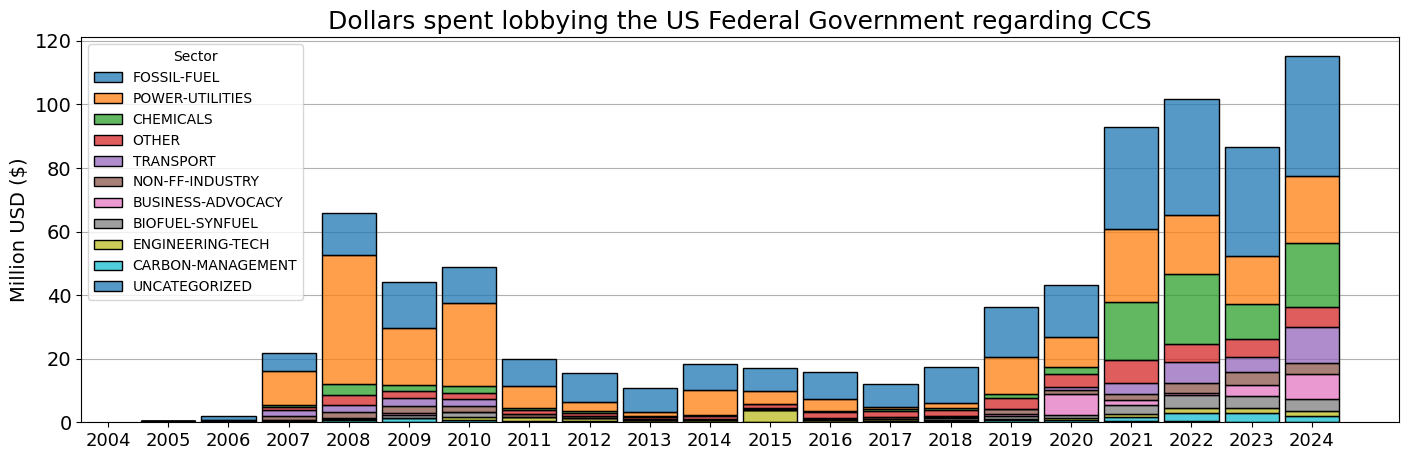

In [31]:
# for histogram hue ordering:
sector_for_group = "very_lumped_sector"
sector_order = list(
    df[[sector_for_group, "lobbying_activity_usd"]]
    .groupby(sector_for_group)
    .sum()
    .sort_values(by="lobbying_activity_usd", ascending=False)
    .index
)

# lobbying_activity_usd
years = list(range(2004, 2025))

tmp_df = (
    df[["filing_year", "lobbying_activity_usd", sector_for_group]]
    .loc[(df.definitely_ccs == 1)]
    .groupby([sector_for_group, "filing_year"])
    .sum()
    .sort_values(by="lobbying_activity_usd", ascending=False)
    .reset_index()
).copy(deep=True)
tmp_df.rename(columns={"very_lumped_sector": "Sector"}, inplace=True)
fig, ax = plt.subplots(1, 1, figsize=(17, 5))
ax = sns.histplot(
    data=tmp_df,
    x="filing_year",
    bins=[0.5 + x for x in years],
    hue="Sector",
    hue_order=sector_order,
    shrink=0.9,
    weights="lobbying_activity_usd",
    multiple="stack",
    palette="tab10",
)
ax.set_xticks(years)
ax.set_xticklabels([str(x) for x in years], fontsize=13)
ax.set_yticks([0.0e8, 0.2e8, 0.4e8, 0.6e8, 0.8e8, 1e8, 1.2e8])
ax.set_yticklabels([0, 20, 40, 60, 80, 100, 120], fontsize=14)
ax.set_axisbelow(True)
ax.yaxis.grid()
ax.set_ylabel("Million USD ($)", fontsize=14)
ax.set_xlabel("")
# ax.legend(ncols=3, loc="upper center")
ax.set_title(
    "Dollars spent lobbying the US Federal Government regarding CCS", fontsize=18
)

### Figure 1: Summary figure of CCUS lobbying efforts, by uber-lumped sector, through time, annotated with key legislative events
Same info as above, but with even-more-lumped data. Colorbar matches treemap

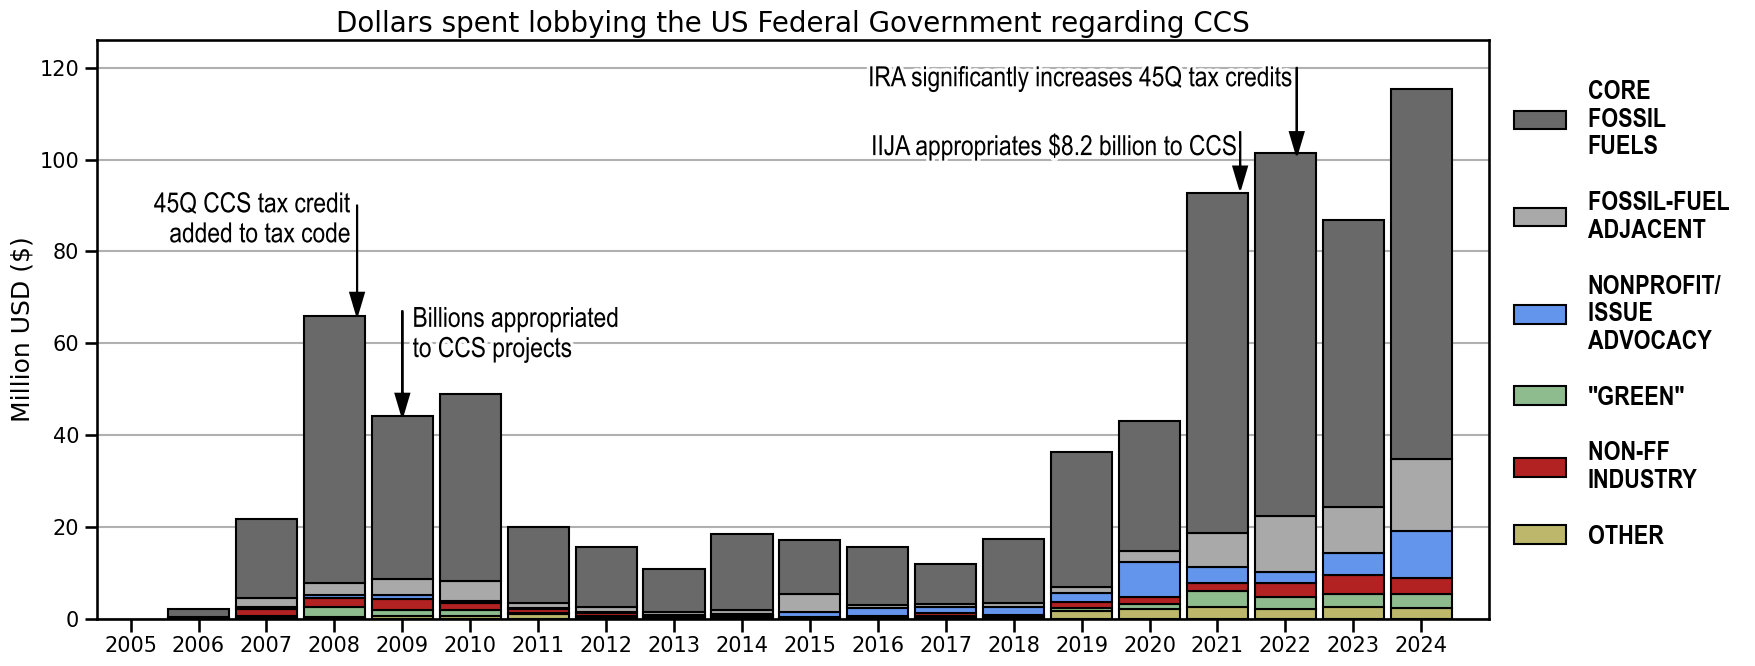

In [32]:
arrowhead_width = 0.2
arrowhead_length = 5000000
arrow_linewidth = 1.5
facecolor = "black"
edgecolor = "black"
annotation_fontsize = 20

sns.set_context("talk")  # for histogram hue ordering
sector_for_group = "uber_lumped_sector"

# assign colors to sector groups:
uber_lumped_color_dict = {
    "Core Fossil Fuels": "dimgrey",
    "Fossil-Fuel Adjacent": "darkgrey",
    "Nonprofit/Issue Advocacy": "cornflowerblue",
    '"Green"': "darkseagreen",
    "Non-FF Industry": "firebrick",
    "Other": "darkkhaki",
    # "UNCATEGORIZED": "darkkhaki",
}
sector_order = list(
    df[[sector_for_group, "lobbying_activity_usd"]]
    .loc[df[sector_for_group] != "UNCATEGORIZED"]
    .groupby(sector_for_group)
    .sum()
    .sort_values(by="lobbying_activity_usd", ascending=False)
    .index
)

# lobbying_activity_usd
years = list(range(2005, 2025))

tmp_df = (
    df[["filing_year", "lobbying_activity_usd", sector_for_group]]
    .loc[(df.definitely_ccs == 1)]
    .groupby([sector_for_group, "filing_year"])
    .sum()
    .sort_values(by="lobbying_activity_usd", ascending=False)
    .reset_index()
).copy(deep=True)
tmp_df.rename(columns={sector_for_group: "Sector"}, inplace=True)
# fig, ax = plt.subplots(
#    1, 1, figsize=(15, 7)
# )  # bigger for paper plot (also change legend line below)
fig, ax = plt.subplots(
    1, 1, figsize=(16, 7)
)  # thinner for presentation (also change legend line below)
ax = sns.histplot(
    data=tmp_df,
    x="filing_year",
    bins=[0.5 + x for x in years],
    hue="Sector",
    hue_order=sector_order,
    shrink=0.9,
    alpha=1,
    weights="lobbying_activity_usd",
    multiple="stack",
    palette=uber_lumped_color_dict,
)
ax.set_xticks(years)
ax.set_xticklabels([str(x) for x in years], fontsize=15)
ax.set_yticks([0.0e8, 0.2e8, 0.4e8, 0.6e8, 0.8e8, 1e8, 1.2e8])
ax.set_yticklabels([0, 20, 40, 60, 80, 100, 120], fontsize=15)
ax.set_axisbelow(True)
ax.yaxis.grid()
ax.set_ylabel("Million USD ($)", fontsize=18)
ax.set_xlabel("")
ax.set_xlim([2004.5, 2025])
ax.set_title(
    "Dollars spent lobbying the US Federal Government regarding CCS", fontsize=20
)


# Create rectangular patches
patches = [
    Patch(
        edgecolor="black",
        facecolor=c,
        label="\n".join(re.findall(r"[^ /]{1,13}(?:[ /]|$)", l.upper())),
    )
    for l, c in uber_lumped_color_dict.items()
]
# scootch the plot so that there is room outside the plot for the legend
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.85, box.height])

ax.legend(
    handles=patches,
    bbox_to_anchor=(1.01, 0.95),
    loc="upper left",
    borderaxespad=0.0,
    labelspacing=1.2,
    frameon=False,
    prop={"family": "Arial Narrow", "weight": "semibold", "size": 19},
)

# --- Add arrows/annotations to the plot ---

# 45Q introduced in the tax code
plt.arrow(
    2008 + 5 / 6 - 0.5,
    90 * 1e6,
    0,
    -19 * 1e6,  # x, y, dx, dy
    lw=1.5,
    head_width=arrowhead_width,
    head_length=arrowhead_length,
    overhang=0,
    fc=facecolor,
    ec=edgecolor,
)
ax.text(
    2008 + 5 / 6 - 0.6,
    82 * 1e6,
    "45Q CCS tax credit\nadded to tax code",
    font="Arial narrow",
    fontsize=annotation_fontsize,
    color="k",
    horizontalalignment="right",
    path_effects=[pe.withStroke(linewidth=5, foreground="w", alpha=0.9)],
)

# Billions in appropriations
plt.arrow(
    2009,
    67 * 1e6,
    0,
    -18 * 1e6,  # x, y, dx, dy
    lw=arrow_linewidth,
    head_width=arrowhead_width,
    head_length=arrowhead_length,
    overhang=0,
    fc=facecolor,
    ec=edgecolor,
)
ax.text(
    2009.15,
    57 * 1e6,
    "Billions appropriated\nto CCS projects",
    font="Arial narrow",
    fontsize=annotation_fontsize,
    color="k",
    horizontalalignment="left",
    path_effects=[pe.withStroke(linewidth=5, foreground="w", alpha=0.9)],
)

# IIJA increases apprpriated bucks for ccs
plt.arrow(
    2021 + 5 / 6 - 0.5,
    106 * 1e6,
    0,
    -7.5 * 1e6,  # x, y, dx, dy
    lw=arrow_linewidth,
    head_width=arrowhead_width,
    head_length=arrowhead_length,
    overhang=0,
    fc=facecolor,
    ec=edgecolor,
)
ax.text(
    2015.9,
    101 * 1e6,
    "IIJA appropriates $8.2 billion to CCS",
    font="Arial narrow",
    fontsize=annotation_fontsize,
    color="k",
    horizontalalignment="left",
    path_effects=[pe.withStroke(linewidth=5, foreground="w", alpha=0.9)],
)

# IRA increases 45Q
plt.arrow(
    2022 + 2 / 3 - 0.5,
    120 * 1e6,
    0,
    -14 * 1e6,  # x, y, dx, dy
    lw=arrow_linewidth,
    head_width=arrowhead_width,
    head_length=arrowhead_length,
    overhang=0,
    fc=facecolor,
    ec=edgecolor,
)
ax.text(
    2022.1,
    116 * 1e6,
    "IRA significantly increases 45Q tax credits",
    font="Arial narrow",
    fontsize=annotation_fontsize,
    color="k",
    horizontalalignment="right",
    path_effects=[pe.withStroke(linewidth=5, foreground="w", alpha=0.9)],
)
fig.tight_layout()
plt.savefig("figure_1.pdf", bbox_inches="tight")

#### Figure 2: Treemap figure that uses area to show relative CCUS-lobbying expenditures of different organizations

In [33]:
#### TREEMAP FIGURE SHOWING WHICH COMPANIES LOBBY FOR CCS
color_dict = {
    "oil and gas": "dimgrey",
    "investor owned utilities": "dimgrey",
    "business advocacy": "cornflowerblue",
    "independent power producers": "dimgrey",
    "coal": "dimgrey",
    "pipelines": "dimgrey",
    "chemicals, refining, and plastics": "dimgrey",
    "municipal and cooperative utilities": "dimgrey",
    "energy technology": "darkgrey",
    "mining and metals": "firebrick",
    "biofuels": "darkgrey",
    "railway": "darkgrey",
    "iron and steel": "firebrick",
    "fuel cell": "darkgrey",
    "renewable energy": "darkseagreen",
    "labor union": "cornflowerblue",
    "food and agriculture": "darkkhaki",
    "environmental": "darkseagreen",
    "finance": "darkkhaki",
    "ccs": "dimgrey",
    "cement": "firebrick",
    "paper products": "firebrick",
    "oilfield services": "dimgrey",
    "air transit": "darkgrey",
    "power sector general": "dimgrey",
    "land transit": "darkgrey",
    "nuclear": "darkseagreen",
    "think tanks and issue advocacy": "cornflowerblue",
    "clean hydrogen": "dimgrey",
    "engineering, technology, and consulting": "darkkhaki",
    "higher education": "cornflowerblue",
    "lng": "dimgrey",
    "government": "cornflowerblue",
    "water transit": "darkgrey",
    "carbon": "darkseagreen",
    "hvac": "darkkhaki",
    "independent research organization": "darkkhaki",
    "ev": "darkseagreen",
    "green hydrogen": "darkseagreen",
    "water": "darkseagreen",
    "other": "darkkhaki",
    "law and public policy": "darkkhaki",
    "professional societies": "cornflowerblue",
    "algae": "dimgrey",
}
# org totals
org_df = (
    df[["organization", "lobbying_activity_usd", "sector"]]
    .groupby(["organization"])
    .agg({"lobbying_activity_usd": "sum", "sector": "first"})
    .sort_values(by=["lobbying_activity_usd"], ascending=False)
)
org_df = org_df.loc[org_df.lobbying_activity_usd > 0]
org_df.reset_index(inplace=True)
org_df["org_with_returns"] = [
    "CONOCO<br>PHILLIPS" if x == "CONOCOPHILLIPS" else x.replace(" ", "<br>")
    for x in org_df.organization
]
org_df["org_with_returns"] = [
    "EXXON<br>MOBIL" if x == "EXXONMOBIL" else x for x in org_df["org_with_returns"]
]
org_df["org_with_returns"] = [
    "TRANS<br>CANADA" if x == "TRANSCANADA" else x for x in org_df["org_with_returns"]
]
# fig, ax = plt.subplots(1, 1, figsize=(17, 10))


# Add custom legend
# assign colors to sector groups:
uber_lumped_color_dict = {
    "": "#FFFFFF",  # white
    "Core Fossil Fuels": "#696969",  # dimgrey
    "Fossil-Fuel Adjacent": "#A9A9A9",  # darkgrey
    "Nonprofit/Issue Advocacy": "#6495ED",  # cornflowerblue
    '"Green"': "#8FBC8F",  # darkseagreen
    "Non-FF Industry": "#B22222",  # firebrick
    "Other": "#BDB76B",  # darkkhaki
}
# Add custom legend using rectangles

legend_items = []

for i, (label, color) in enumerate(uber_lumped_color_dict.items()):
    legend_items.append(
        go.Scatter(
            x=[None],
            y=[None],
            mode="markers",
            textfont=dict(size=10),
            textposition="middle right",
            marker=dict(
                size=25, line=dict(width=0, color="white"), color=color, symbol="square"
            ),
            name=label,
        )
    )

# Combine treemap and legend
fig = make_subplots(rows=1, cols=1)
fig.add_traces(
    px.treemap(
        org_df,
        path=["org_with_returns"],
        values="lobbying_activity_usd",
        color="sector",
        width=1200,
        height=800,
        color_discrete_map=color_dict,
    ).data
)

for item in legend_items:
    fig.add_trace(
        item,
    )
fig.update_layout(
    font=dict(size=20),
    margin=dict(t=1, l=15, r=15, b=15),
    # showlegend=True,
    xaxis_visible=False,
    yaxis_visible=False,
    paper_bgcolor="white",
    plot_bgcolor="white",
    autosize=True,
    yaxis_scaleanchor="x",  # <- updates 1st subplot :)
)
fig.update_traces(marker_line_width=0.05)
fig.show()
fig.write_image("figure_2.pdf", scale=6, width=1200, height=800)

### Figure 3: Higher education CCS lobbying efforts through time

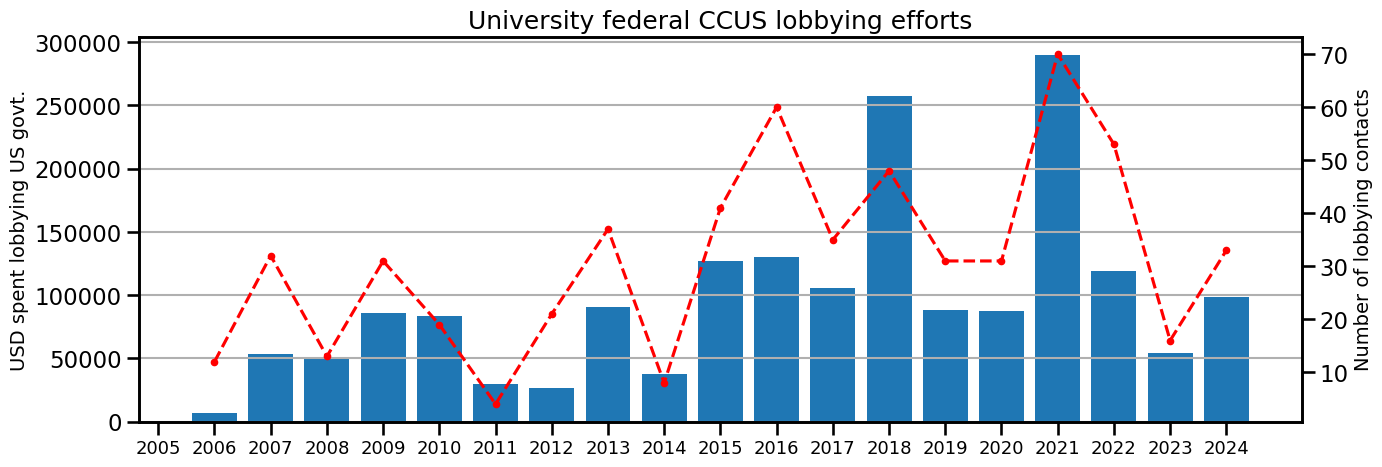

In [34]:
sns.set_context("talk")  # for histogram hue ordering:

# lobbying_activity_usd
years = list(range(2005, 2025))

tmp_df = (
    df[["filing_year", "lobbying_activity_usd", "n_entities_lobbied"]]
    .loc[(df.definitely_ccs == 1) & (df.sector == "higher education")]
    .groupby("filing_year")
    .sum()
    .reset_index()
).copy(deep=True)

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax2 = ax.twinx()
ax.bar(
    x=tmp_df.filing_year,
    height=tmp_df.lobbying_activity_usd,
)
ax2.plot(tmp_df.filing_year, tmp_df.n_entities_lobbied, "r.--")
ax2.set_ylabel("Number of lobbying contacts", fontsize=14)
ax.set_xticks(years)
ax.set_xticklabels([str(x) for x in years], fontsize=13)
ax.yaxis.grid()
ax.set_ylabel("USD spent lobbying US govt.", fontsize=14)
ax.set_xlabel("")
# ax.legend(ncols=3, loc="upper center")#
ax.set_title("University federal CCUS lobbying efforts", fontsize=18)
fig.savefig("figure_3.pdf")

### Quantify steel industry's environmental lobbying that *DOESNT* relate to CCS

In [35]:
steel_df = trim_dates(
    pd.read_csv(PATH_TO_POSTPROCESSED_STEEL_INDUSTRY_FILINGS),
    yr=2024,
    period=4,
    how="lte",
    yr_col="filing_year",
    period_col="filing_period",
)
print("We'll focus on activities that are not even potentially CCS activities: ")
steel_df.potentially_ccs.value_counts()

We'll focus on activities that are not even potentially CCS activities: 


potentially_ccs
0    6171
1     232
Name: count, dtype: int64

In [36]:
# identify lobbying activities dealing with 'environmental' subjects
steel_df["environmental"] = [
    1
    if terms_present(
        x,
        [
            "environment",
            "sustainability",
            "sustain",
            "renewable",
            "climate",
            "net zero",
            "greenhouse",
            "paris accord",
            "low carbon",
            "carbon neutral",
            "carbon-neutral",
            "emission",
            "air quality",
            "recycle",
            "recycled",
            "recycling",
            "carbon dioxide",
            "solar",
            "wind",
            "clean air",
            "co2",
            "green hydrogen",
            "carbondioxide",
            "GHG",
            "pollution",
            "green steel",
            "pollutant",
            "green h2",
            "zero emission",
            "reduced carbon",
            "zero-emission",
            "zero carbon",
            "zerocarbon",
            "lowcarbon",
            "carbonneutral",
            "earth friendly",
            "cafe standard",
            "low waste",
        ],
    )
    else 0
    for x in steel_df.cleaned_activity_description
]

In [37]:
total_non_ccs_environmental_dollars_steel = steel_df.loc[
    (steel_df.environmental == 1)
    & (steel_df.potentially_ccs == 0)
    & (steel_df.sector == "iron and steel")
].lobbying_activity_usd.sum()

total_ccs_dollars_steel = steel_df.loc[
    (steel_df.definitely_ccs == 1) & (steel_df.sector == "iron and steel")
].lobbying_activity_usd.sum()
print(
    f"The steel industry spent ${total_non_ccs_environmental_dollars_steel:.0f} between 2005 and 2024 lobbying regarding non-CCS environmental topics"
)
print(
    f"The steel industry spent ${total_ccs_dollars_steel:.0f} between 2005 and 2024 lobbying about CCS"
)
print(
    f"That's a {int(total_non_ccs_environmental_dollars_steel/total_ccs_dollars_steel)}:1 difference."
)

The steel industry spent $54588051 between 2005 and 2024 lobbying regarding non-CCS environmental topics
The steel industry spent $5194245 between 2005 and 2024 lobbying about CCS
That's a 10:1 difference.


### Tables for Environmental Science and Policy paper

#### Table A.4: Total CCUS lobbying expenditures by sector, 2005-2024

In [39]:
# build table of sector-specific CCUS lobbying totals
tmp_calc_df = (
    df[["very_lumped_sector", "sector", "lobbying_activity_usd", "organization"]]
    .groupby("organization")
    .agg(
        {"very_lumped_sector": "first", "sector": "first", "lobbying_activity_usd": sum}
    )
    .sort_values(by=["sector", "lobbying_activity_usd"], ascending=False)
    .reset_index()
)  # .to_clipboard()
tmp_calc_df.groupby("sector").agg(
    {
        "very_lumped_sector": "first",
        "organization": "first",
        "lobbying_activity_usd": sum,
    }
).sort_values(by="lobbying_activity_usd", ascending=False).to_clipboard()

#### Table A.5 Top 50 organizations with the largest total CCUS-focused lobbying expenditures, 2005-2024

In [40]:
# ### Compute the fraction of the total CCS lobbying done by heavy hitters in the CCS lobbying space

big_spenders_total_df = trim_dates(
    pd.read_csv(PATH_TO_POSTPROCESSED_BIG_SPENDERS_FILINGS),
    yr=2024,
    period=4,
    how="lte",
    yr_col="filing_year",
    period_col="filing_period",
)

big_spenders_total_df.lobbying_activity_usd.fillna(0, inplace=True)

ccs_lobbying_df = (
    big_spenders_total_df[
        [
            "organization",
            "lobbying_activity_usd",
        ]
    ]
    .loc[big_spenders_total_df.definitely_ccs == 1]
    .groupby("organization")
    .sum()
    .sort_values(by="lobbying_activity_usd", ascending=False)
)
ccs_lobbying_df.columns = ["ccs_lobbying_activity_usd_2005_2024"]
total_lobbying_df = (
    big_spenders_total_df[
        ["organization", "lobbying_activity_usd", "very_lumped_sector", "sector"]
    ]
    .groupby("organization")
    .agg(
        {"lobbying_activity_usd": sum, "very_lumped_sector": "first", "sector": "first"}
    )
    .sort_values(by="lobbying_activity_usd", ascending=False)
)
total_lobbying_df.columns = [
    "all_lobbying_activity_usd_2005_2024",
    "general sector",
    "detailed sector",
]

ccs_fraction_df = total_lobbying_df.merge(
    ccs_lobbying_df, left_index=True, right_index=True, how="right"
)
ccs_fraction_df["ccs_fraction"] = [
    ccs / a if a > 0 else 0
    for ccs, a in zip(
        ccs_fraction_df["ccs_lobbying_activity_usd_2005_2024"],
        ccs_fraction_df["all_lobbying_activity_usd_2005_2024"],
    )
]
ccs_fraction_df = ccs_fraction_df[
    [
        "ccs_fraction",
        "general sector",
        "detailed sector",
        "all_lobbying_activity_usd_2005_2024",
        "ccs_lobbying_activity_usd_2005_2024",
    ]
].sort_values(
    by="ccs_lobbying_activity_usd_2005_2024",
    ascending=False,
)
ccs_fraction_df.head(50).to_clipboard()
ccs_fraction_df.head(50)

,ccs_fraction,general sector,detailed sector,all_lobbying_activity_usd_2005_2024,ccs_lobbying_activity_usd_2005_2024
organization,,,,,
OCCIDENTAL PETROLEUM,0.369171,FOSSIL-FUEL,oil and gas,2.074995e+08,7.660287e+07
SOUTHERN COMPANY,0.179702,POWER-UTILITIES,investor owned utilities,3.067445e+08,5.512273e+07
EXXONMOBIL,0.124047,FOSSIL-FUEL,oil and gas,3.446525e+08,4.275299e+07
AMERICAN CHEMISTRY COUNCIL,0.103635,CHEMICALS,"chemicals, refining, and plastics",2.634642e+08,2.730409e+07
CHEVRON,0.080064,FOSSIL-FUEL,oil and gas,3.027402e+08,2.423867e+07
SHELL,0.111182,FOSSIL-FUEL,oil and gas,2.023855e+08,2.250166e+07
EDISON ELECTRIC INSTITUTE,0.063293,POWER-UTILITIES,investor owned utilities,3.168839e+08,2.005667e+07
BP AMERICA,0.109716,FOSSIL-FUEL,oil and gas,1.666045e+08,1.827913e+07
AMERICAN ELECTRIC POWER,0.121490,POWER-UTILITIES,investor owned utilities,1.493925e+08,1.814972e+07


### Informational tables for ESP paper

#### Table A.2: Bills mostly or entirely focused on CCS

In [41]:
acts_df = pd.read_csv(DATA_DIR / Path("bills_mostly_ccs.csv"))
acts_df.fillna(-1, inplace=True)

acts_df.columns = [
    "Name of legislation",
    "Year",
    "Congress",
    "House bill number",
    "Senate bill number",
]
for c in ["House bill number", "Senate bill number", "Year", "Congress"]:
    acts_df[c] = [str(int(x)) if x > -1 else "" for x in acts_df[c]]
acts_df.sort_values(
    by=["Congress", "House bill number", "Senate bill number"],
    ascending=True,
    inplace=True,
)
acts_df.to_csv("mostly_ccs_table_a3.csv")

acts_df["House bill number"] = [
    "H.R." + h if h != "" else "" for h in acts_df["House bill number"]
]
acts_df["Senate bill number"] = [
    "S." + s if s != "" else "" for s in acts_df["Senate bill number"]
]
acts_df["bill numbers"] = [
    "" if (h == "") and (s == "") else f"({h}, {s})"
    for h, s in zip(acts_df["House bill number"], acts_df["Senate bill number"])
]
acts_df["bill numbers"] = [
    b.replace(", ", "") if ((h == "") | (s == "")) and (b != "") else b
    for b, h, s in zip(
        acts_df["bill numbers"],
        acts_df["House bill number"],
        acts_df["Senate bill number"],
    )
]
acts_df["Bills"] = [
    f"{n} {b}" for n, b in zip(acts_df["Name of legislation"], acts_df["bill numbers"])
]
acts_df[["Congress", "Bills"]].groupby("Congress").agg(
    lambda x: "\n".join(list(x))
).to_csv("congress_bill_names.csv")

#### Table A.3: List all detailed sectors, the corresponding general sector, and the set of organizations that lobbyied about CCS b/w 2005 and 2024

In [42]:
sectors_df = (
    df.loc[df.definitely_ccs == 1][["organization", "sector"]]
    .groupby("organization")
    .first()
    .reset_index()
)
lumping_df = (
    df[["sector", "uber_lumped_sector"]].groupby("sector").first().reset_index()
)
sectors_df = (
    sectors_df[["organization", "sector"]]
    .groupby("sector")
    .agg(lambda x: "\n".join(list(x)))
).reset_index()
sectors_df[["col1", "col2", "col3"]] = sectors_df["organization"].apply(
    lambda x: pd.Series(split_on_char3(x))
)
# join multi-column organization name table to the list of detailed sector names with general sectors specified in parentheses
sectors_df = sectors_df.merge(lumping_df, on="sector")
sectors_df["sector"] = [
    f"{s} ({u})" for s, u in zip(sectors_df.sector, sectors_df.uber_lumped_sector)
]
# save resulting table to file
sectors_df.to_csv("companies_in_sectors.csv")